 In this tutorial, we will show the wide range of derived quantities that can be computed as a post process in FESTIM.

# Test case

The test case for this tutorial will be a 2D composite domain with 2 traps.
First, the mesh needs to be described.

In [1]:
parameters = {}

In [2]:
from fenics import Point, RectangleMesh, CompiledSubDomain, MeshFunction

# creating a 2D mesh with FEniCS
nx = ny = 15
mesh_fenics = RectangleMesh(Point(0, 0), Point(1e-7, 1e-7), nx, ny)

# marking volumes
volume_markers = MeshFunction("size_t", mesh_fenics, mesh_fenics.topology().dim())

tol = 1e-14
subdomain_1 = CompiledSubDomain('x[1] <= 0.5e-7 + tol || x[0] <= 0.5e-7 + tol', tol=tol)
subdomain_2 = CompiledSubDomain('x[1] >= 0.5e-7 - tol && x[0] >= 0.5e-7 - tol', tol=tol)

volume_markers.set_all(1)
subdomain_1.mark(volume_markers, 1)
subdomain_2.mark(volume_markers, 2)

# marking surfaces
surface_markers = MeshFunction("size_t", mesh_fenics, mesh_fenics.topology().dim() - 1)

left_surface = CompiledSubDomain('on_boundary && near(x[0], 0, tol)',
                                tol=tol)
bottom_surface = CompiledSubDomain('on_boundary && near(x[1], 0, tol)',
                                     tol=tol)
surface_markers.set_all(0)
left_surface.mark(surface_markers, 1)
bottom_surface.mark(surface_markers, 2)

# creating mesh with FESTIM
parameters["mesh_parameters"] = {
    "mesh": mesh_fenics,
    "meshfunction_cells": volume_markers,
    "meshfunction_facets": surface_markers,
}

The two materials will have dummy values for diffusivities.

In [3]:
parameters["materials"] = [{
    "E_D": 0.39,
    "D_0": 4.1e-7,
    "id": 1
},
    {
    "E_D": 0.5,
    "D_0": 5e-7,
    "id": 2
},
]

The same traps as in the Ogorodnikova demo will be taken.

In [4]:
parameters["traps"] = [
        {
            "k_0": 3.8e-17,
            "E_k": 0.39,
            "p_0": 1e13,
            "E_p": 0.87,
            "density": 1.3e-3*6.3e28,
            "materials": [1]
        },
        {
            "k_0": 3.8e-17,
            "E_k": 0.39,
            "p_0": 1e13,
            "E_p": 1.0,
            "density": 4e-4*6.3e28,
            "materials": [2]
        },
]

Two Dirichlet boundary conditions will be imposed on the left surface (id 1) and the bottom surface (id 2).

All the other surfaces are insulated.

In [5]:
parameters["boundary_conditions"] = [
            {
                "surfaces": [1],
                "value": 1e15,
                "type": "dc"
            },
            {
                "surfaces": [2],
                "value": 0,
                "type": "dc"
            },
    ]

The temperature will increase linearly with time.

In [6]:
from FESTIM import t

parameters["temperature"] = {
    "type": "expression",
    "value": 400 + 3*t
    }

In [7]:
solving_parameters = {
    "final_time": 10,
    "initial_stepsize": 0.005,
    "adaptive_stepsize": {
        "stepsize_change_ratio": 1.1,
        "dt_min": 1e-5
    },
    "newton_solver": {
        "absolute_tolerance": 1e0,
        "relative_tolerance": 1e-9,
        "maximum_iterations": 50,
    },
    "traps_element_type": "DG",
}

parameters["solving_parameters"] = solving_parameters

In [8]:
folder = 'solution_derived_quantities'

exports = {
    "derived_quantities": {
        "folder": folder,
        "file": "derived_quantities.csv",
        "total_volume": [
            {
                "field": "solute",
                "volumes": [1, 2]
            },
            {
                "field": 1,
                "volumes": [1]
            },
            {
                "field": 2,
                "volumes": [2]
            },
            {
                "field": "retention",
                "volumes": [1, 2]
            },
        ],
        "surface_flux": [
            {
                "field": "solute",
                "surfaces": [0, 1, 2]
            },
        ],
        "average_volume": [
            {
                "field": "solute",
                "volumes": [1, 2]
            },
            {
                "field": "1",
                "volumes": [1]
            },
            {
                "field": "2",
                "volumes": [2]
            },
            {
                "field": "T",
                "volumes": [1]
            }
        ],
        "total_surface": [
            {
                "field": "solute",
                "surfaces": [0, 1, 2]
            }
        ],
        "maximum_volume": [
            {
                "field": "retention",
                "volumes": [1, 2]
            }
        ]
    },
}

parameters["exports"] = exports

# 2. Running the simulation

Now that all the parameters have been set, the simulation can be performed using the `run()` function which takes as only argument the dict `parameters`.

In [9]:
from FESTIM.generic_simulation import run

output = run(parameters)

Defining initial values
Defining variational problem
Defining boundary conditions
Time stepping...
s3.48 %        10.3 s    Ellapsed time so far: 17.8 s


# 3. Output
Now that the simulation is over, several objects such as the parameters dict, the mesh, the temperature and the desorption table  are stored in `output`.

Let us see what `output` contains:

In [10]:
print(output.keys())

dict_keys(['parameters', 'mesh', 'derived_quantities'])


In [11]:
import numpy as np
np.set_printoptions(threshold=20)
print(output["derived_quantities"][0])
print(np.array(output["derived_quantities"]))


['t(s)', 'Flux surface 0: solute', 'Flux surface 1: solute', 'Flux surface 2: solute', 'Average solute volume 1', 'Average solute volume 2', 'Average 1 volume 1', 'Average 2 volume 2', 'Average T volume 1', 'Maximum retention volume 1', 'Maximum retention volume 2', 'Total solute volume 1', 'Total solute volume 2', 'Total 1 volume 1', 'Total 2 volume 2', 'Total retention volume 1', 'Total retention volume 2', 'Total solute surface 0', 'Total solute surface 1', 'Total solute surface 2']
[['t(s)' 'Flux surface 0: solute' 'Flux surface 1: solute' ...,
  'Total solute surface 0' 'Total solute surface 1'
  'Total solute surface 2']
 ['0.005' '-52.74381425135655' '30098.796396095655' ...,
  '14297347.24144902' '96666666.66666666' '0.0']
 ['0.0105' '-39.58562170907981' '26153.05689159786' ...,
  '17134992.86079046' '96666666.66666666' '0.0']
 ..., 
 ['8.543597385058122' '10.428452839579922' '18797.85784059937' ...,
  '106353203.1289213' '96666666.66666666' '0.0']
 ['9.402957123563935' '14.139

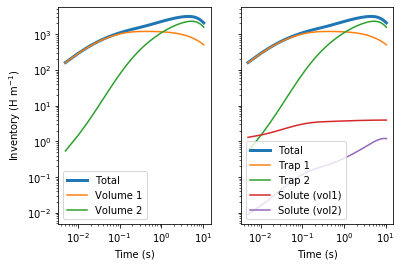

In [12]:
derived_quantities = np.array(output["derived_quantities"][1:])
header = output["derived_quantities"][0]

t = derived_quantities[:, output["derived_quantities"][0].index("t(s)")]


retention_1 = derived_quantities[:, header.index('Total retention volume 1')]
retention_2 = derived_quantities[:, header.index('Total retention volume 2')]

trap_1 = derived_quantities[:, header.index('Total 1 volume 1')]
trap_2 = derived_quantities[:, header.index('Total 2 volume 2')]

solute_1 = derived_quantities[:, header.index('Total solute volume 1')]
solute_2 = derived_quantities[:, header.index('Total solute volume 2')]

# plot
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(t, retention_1 + retention_2, linewidth=3, label="Total")
ax1.plot(t, retention_1, label="Volume 1")
ax1.plot(t, retention_2, label="Volume 2")
ax1.set_ylabel(r"Inventory (H m$^{-1}$)")
ax1.set_xlabel(r"Time (s)")
ax1.set_xscale("log")
ax1.legend()

ax2.plot(t, retention_1 + retention_2, linewidth=3, label="Total")
ax2.plot(t, trap_1, label="Trap 1")
ax2.plot(t, trap_2, label="Trap 2")
ax2.plot(t, solute_1, label="Solute (vol1)")
ax2.plot(t, solute_2, label="Solute (vol2)")
ax2.set_xlabel(r"Time (s)")
ax2.legend()
ax2.set_xscale("log")

ax1.set_yscale("log")
plt.show()

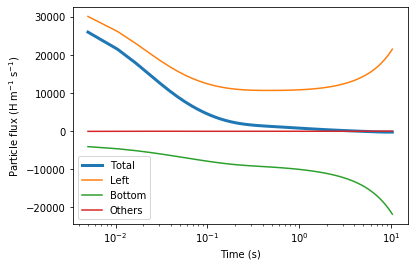

In [13]:
flux_other_surfaces = derived_quantities[:, header.index('Flux surface 0: solute')]
flux_left = derived_quantities[:, header.index('Flux surface 1: solute')]
flux_bottom = derived_quantities[:, header.index('Flux surface 2: solute')]
flux_total = flux_left + flux_bottom + flux_other_surfaces

plt.plot(t, flux_total, linewidth=3, label="Total")
plt.plot(t, flux_left, label="Left")
plt.plot(t, flux_bottom, label="Bottom")
plt.plot(t, flux_other_surfaces, label="Others")
plt.ylabel(r"Particle flux (H m$^{-1}$ s$^{-1}$)")
plt.xlabel(r"Time (s)")
plt.xscale("log")
plt.legend()
plt.show()

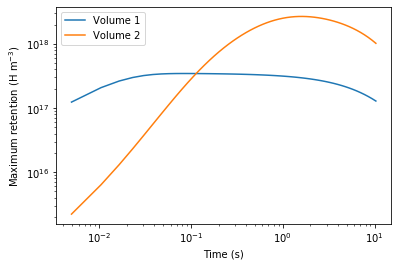

In [14]:
max_1 = derived_quantities[:, header.index('Maximum retention volume 1')]
max_2 = derived_quantities[:, header.index('Maximum retention volume 2')]

plt.loglog(t, max_1, label="Volume 1")
plt.loglog(t, max_2, label="Volume 2")
plt.ylabel(r"Maximum retention (H m$^{-3}$)")
plt.xlabel(r"Time (s)")
plt.legend()
plt.show()

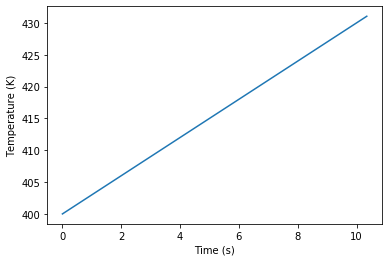

In [15]:
T = derived_quantities[:, header.index('Average T volume 1')]
plt.plot(t, T)
plt.ylabel(r"Temperature (K)")
plt.xlabel(r"Time (s)")
plt.show()

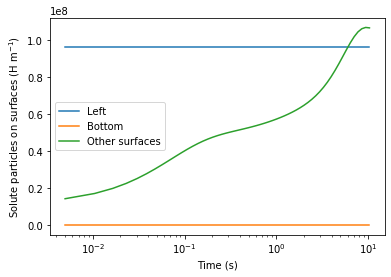

In [16]:
solute_surf_0 = derived_quantities[:, header.index('Total solute surface 0')]
solute_surf_1 = derived_quantities[:, header.index('Total solute surface 1')]
solute_surf_2 = derived_quantities[:, header.index('Total solute surface 2')]

plt.plot(t, solute_surf_1, label="Left")
plt.plot(t, solute_surf_2, label="Bottom")
plt.plot(t, solute_surf_0, label="Other surfaces")
plt.ylabel(r"Solute particles on surfaces (H m$^{-1}$)")
plt.xlabel(r"Time (s)")
plt.xscale("log")
plt.legend()
plt.show()